# Segmentación de Clientes para Optimizar Estrategias de Marketing Personalizadas

## 1. Importar Librerías

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Cargar los datos

In [6]:
# Reemplaza el nombre del archivo por el tuyo
df = pd.read_csv("../data/output.csv")

# Ver los primeros registros
df.head()

,passenger_email,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
0,hx.xxx@hotmail.com,49,80.051020,0.0612,0.0,1.0000,93
1,jxxxxxx@icloud.com,42,61.904762,0.1667,0.0,0.0476,145
2,Jxxxxxxxxxxx@gmail.com,38,86.105263,0.9211,0.0,1.0000,104
3,gxxxxxxxxxxxxxxxxx@gmail.com,38,63.815789,0.3684,0.0,0.0000,385
4,exxxxxx_xx@hotmail.com,37,68.243243,3.9459,0.0,0.9730,89


## 3. Descripción de la tabla

| Campo                     | Descripción                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| passenger_id              | Correo único del pasajero (solo para referencia, no se usa en K-Means)|     |
| total_tickets             | Número total de tickets comprados en los últimos 6 meses                    |
| avg_spent                 | Gasto promedio por ticket                                                   |
| days_in_advance_avg       | Promedio de días de anticipación entre la compra y la fecha del viaje       |
| discount_rate             | Proporción de tickets comprados con descuento (0 a 1)                       |
| web_rate                  | Porcentaje de compras realizadas a través de la web                         |
| last_purchase_days_ago    | Días transcurridos desde la última compra hasta hoy                         |


In [7]:
# Verificar información del DataFrame
df.describe()

,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
count,18292.000000,18292.000000,18292.000000,18292.0,18292.000000,18292.000000
mean,3.472338,98.288875,4.606713,0.0,0.843784,250.772906
std,2.769072,43.529015,8.132991,0.0,0.343252,111.316765
min,2.000000,5.000000,0.000000,0.0,0.000000,87.000000
25%,2.000000,69.000000,1.000000,0.0,1.000000,163.000000
50%,2.000000,85.000000,2.000000,0.0,1.000000,226.000000
75%,4.000000,117.000000,4.666700,0.0,1.000000,342.000000
max,49.000000,405.000000,112.000000,0.0,1.000000,481.000000


In [8]:
df = df.select_dtypes(include=[np.number]).copy()
df.head()

,total_tickets,avg_spent,days_in_advance_avg,discount_rate,web_rate,last_purchase_days_ago
0,49,80.051020,0.0612,0.0,1.0000,93
1,42,61.904762,0.1667,0.0,0.0476,145
2,38,86.105263,0.9211,0.0,1.0000,104
3,38,63.815789,0.3684,0.0,0.0000,385
4,37,68.243243,3.9459,0.0,0.9730,89


array([[<Axes: title={'center': 'total_tickets'}>,
        <Axes: title={'center': 'avg_spent'}>],
       [<Axes: title={'center': 'days_in_advance_avg'}>,
        <Axes: title={'center': 'discount_rate'}>],
       [<Axes: title={'center': 'web_rate'}>,
        <Axes: title={'center': 'last_purchase_days_ago'}>]], dtype=object)

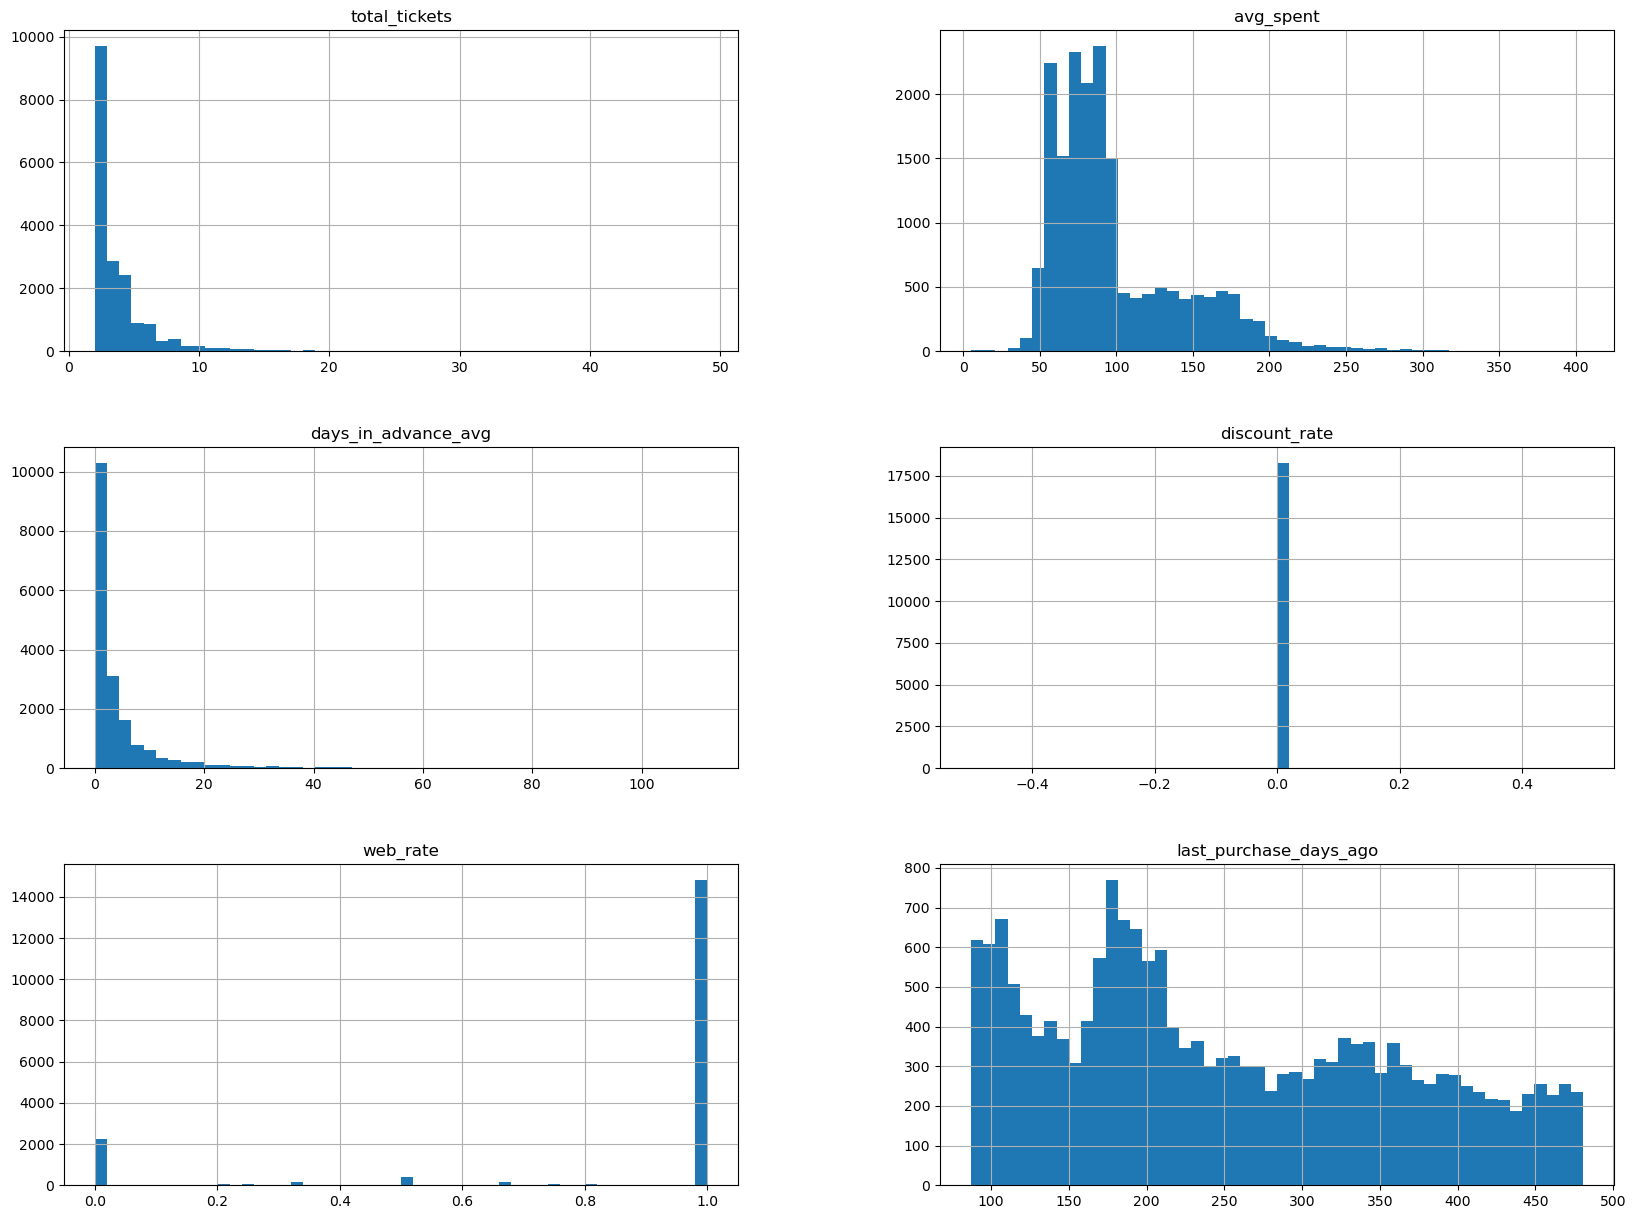

In [9]:
df.hist(bins=50, figsize=(20, 15))

De estos histogramas podemos observar:

- Segun la data, `discount_rate` siempre es 0, entonces no la necesitamos.
- `last_purchase_days_ago` tiene una distribucion compleja y se usara sin cambios.
- `web_rate` tiene una distribucion en U y los valores 0 y 1 son importantes (0 = 100% de las compras son en persona o telefono / 1 = 100% de las compras son en linea)
- Las otras 3 tienen sesgo izquierdo, asi que se usara logaritmo para suavisarla.

In [10]:
df['total_tickets_log'] = np.log1p(df['total_tickets'])
df['avg_spent_log'] = np.log1p(df['avg_spent'])
df['days_in_advance_avg_log'] = np.log1p(df['days_in_advance_avg'])

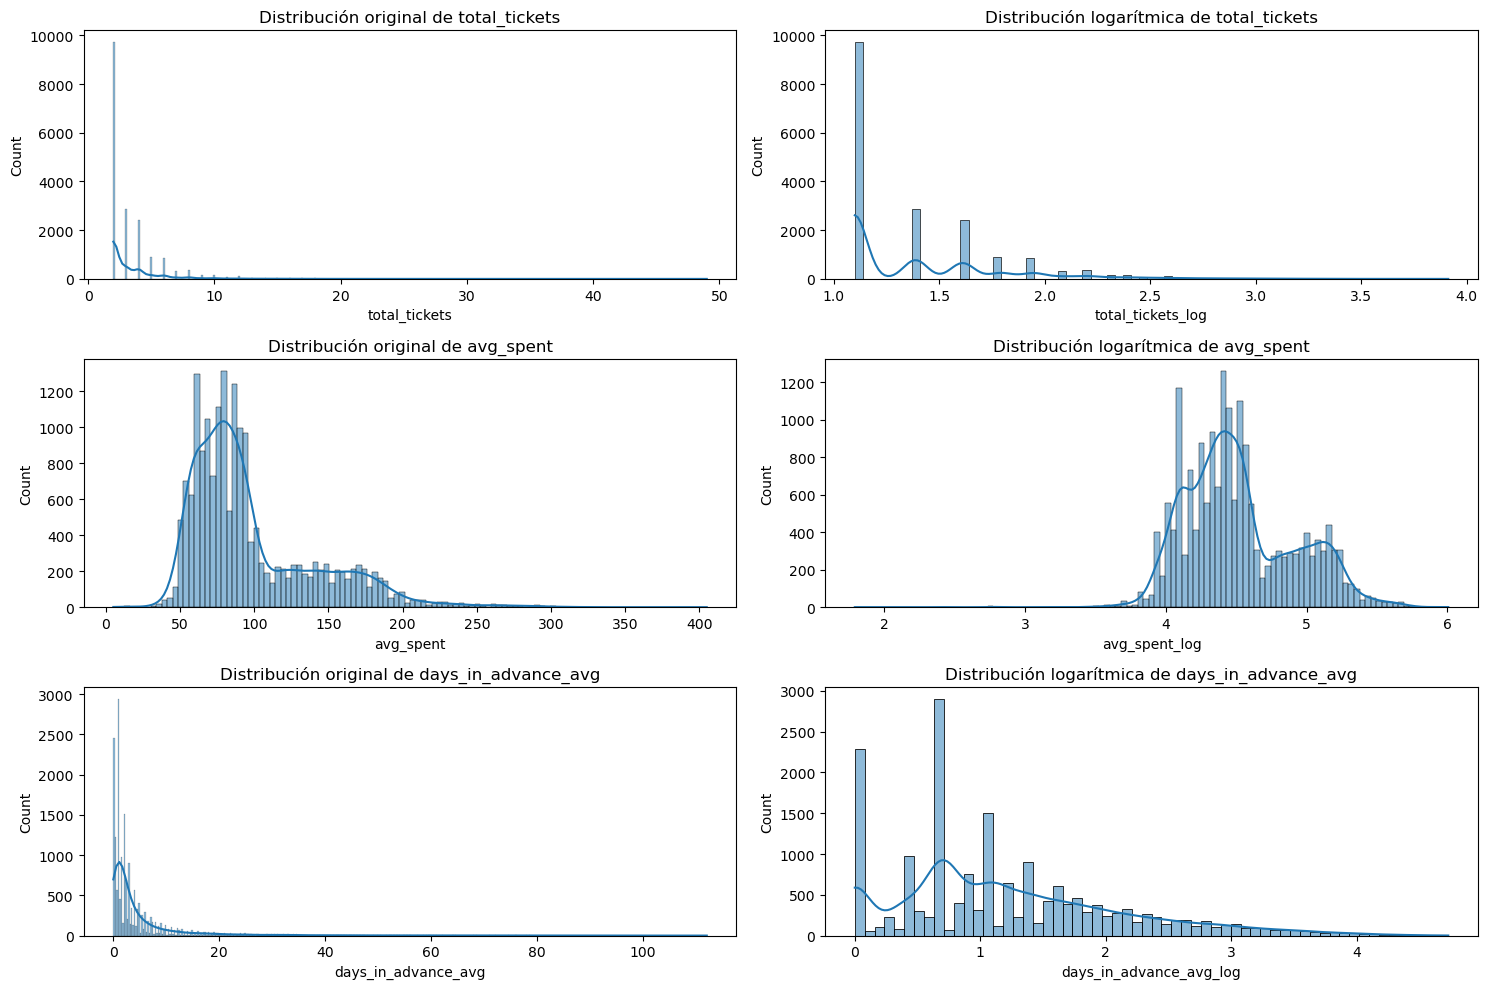

In [11]:
# Mostrar histogramas que comparen las distribuciones de las variables originales y las transformadas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(['total_tickets', 'avg_spent', 'days_in_advance_avg']):
    sns.histplot(df[col], ax=axes[i*2], kde=True)
    axes[i*2].set_title(f'Distribución original de {col}')
    
    sns.histplot(df[f'{col}_log'], ax=axes[i*2 + 1], kde=True)
    axes[i*2 + 1].set_title(f'Distribución logarítmica de {col}')

plt.tight_layout()


In [12]:
col_features = ['total_tickets_log', 'avg_spent_log', 'days_in_advance_avg_log', 'web_rate', 'last_purchase_days_ago']
df_for_oa = df[col_features]

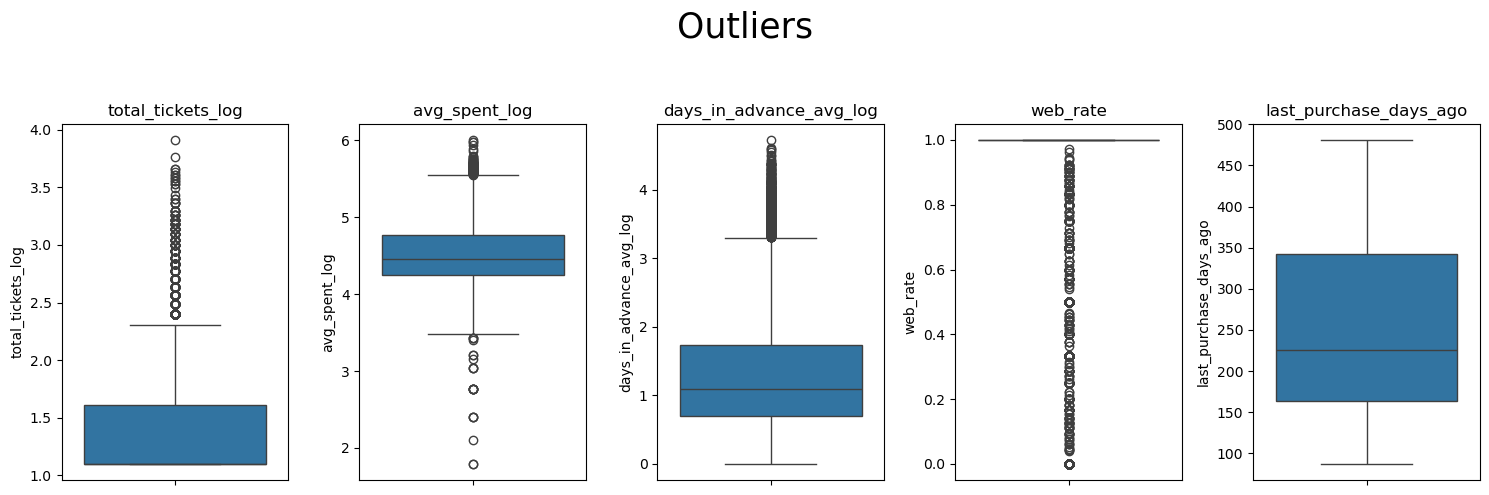

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
fig.suptitle('Outliers\n', size=25)

# Aplanar la matriz de axes para facilitar la indexación
axes = axes.flatten()

for i, col in enumerate(df_for_oa.columns):
    ax = axes[i]
    sns.boxplot(ax=ax, data=df_for_oa[col])
    ax.set_title(col)


plt.tight_layout()  # Ajusta el espaciado
plt.show()


In [14]:
from sklearn.ensemble import IsolationForest

# Ajustar el modelo Isolation Forest, asumiento 5% de contaminación (anomalías/outliers)
iso_forest = IsolationForest(n_estimators=300, bootstrap=True, contamination=0.05, random_state=42)
iso_forest.fit(df_for_oa)
anomaly = iso_forest.predict(df_for_oa)

# Agregar la columna de anomalías al DataFrame usado para el análisis
df_for_oa['anomaly'] = anomaly
# Agregar la columna de anomalías al DataFrame original
df['anomaly'] = anomaly

df_for_oa.head(10)

C:\Users\dimacros\AppData\Local\Temp\ipykernel_38988\58401343.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_oa['anomaly'] = anomaly


,total_tickets_log,avg_spent_log,days_in_advance_avg_log,web_rate,last_purchase_days_ago,anomaly
0,3.912023,4.395079,0.059400,1.0000,93,-1
1,3.761200,4.141622,0.154179,0.0476,145,-1
2,3.663562,4.467117,0.652898,1.0000,104,-1
3,3.663562,4.171549,0.313642,0.0000,385,-1
4,3.637586,4.237626,1.598559,0.9730,89,-1
5,3.610918,4.518462,0.054109,1.0000,114,-1
6,3.610918,4.342723,1.945910,0.0000,95,-1
7,3.583519,4.022286,1.154173,0.0000,103,-1
8,3.583519,4.606883,2.431101,0.0000,173,-1
9,3.555348,4.747231,0.137237,1.0000,203,-1


In [15]:
anomaly = df.loc[df_for_oa['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('El numero total de outliers es:', len(anomaly))

df_for_oa = df_for_oa.drop(anomaly_index, axis = 0).reset_index(drop=True)
df_for_oa = df_for_oa.drop(columns=['anomaly'])

El numero total de outliers es: 915


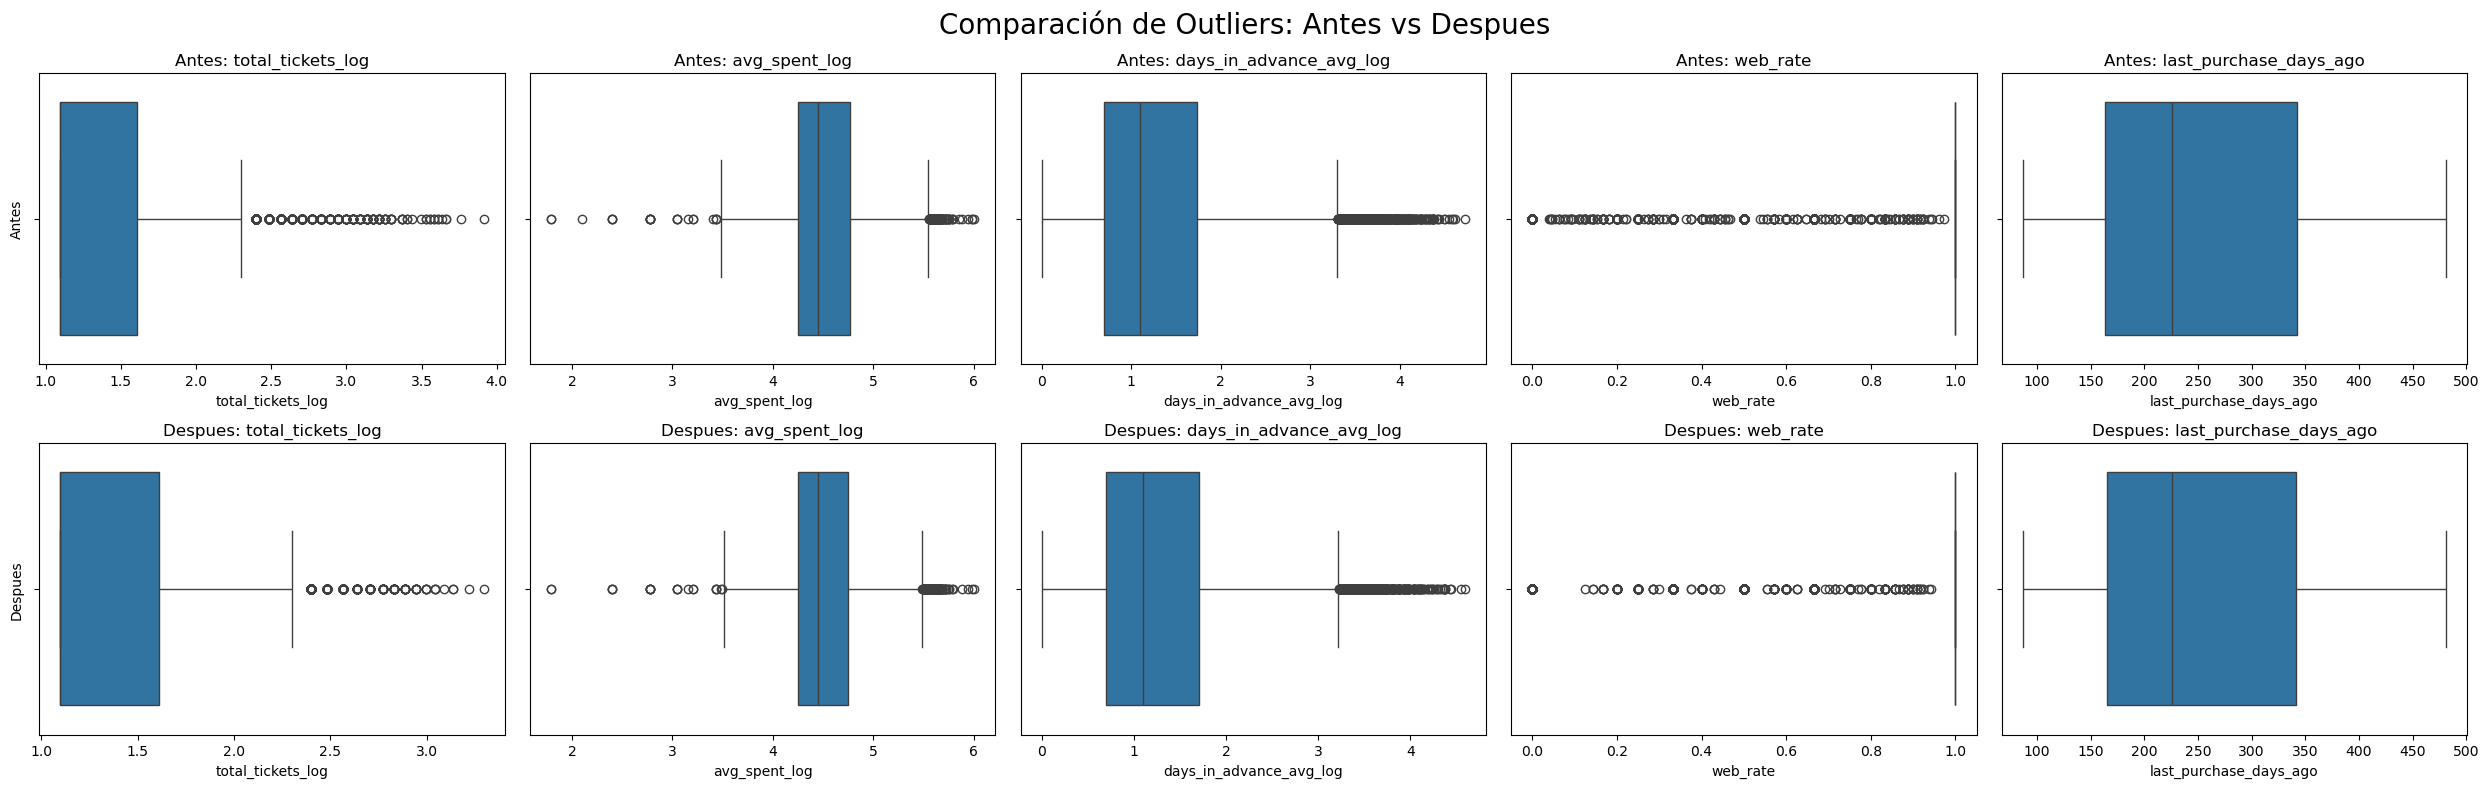

In [16]:
# Numero de variables numéricas
num_vars = len(df_for_oa.columns)

# Crear subplots para comparar los boxplots de las variables antes y después de eliminar outliers
fig, axes = plt.subplots(nrows=2, ncols=num_vars, figsize=(5 * num_vars, 8), sharey='row')
fig.suptitle('Comparación de Outliers: Antes vs Despues', fontsize=20)

for i, col in enumerate(df_for_oa.columns):
    # ANTES
    sns.boxplot(ax=axes[0, i], x=df[col])
    axes[0, i].set_title(f'Antes: {col}', fontsize=12)

    # DESPUES
    sns.boxplot(ax=axes[1, i], x=df_for_oa[col])
    axes[1, i].set_title(f'Despues: {col}', fontsize=12)

# Etiqueta de los ejes
axes[0, 0].set_ylabel('Antes')
axes[1, 0].set_ylabel('Despues')

plt.tight_layout() 
plt.show()


In [17]:
# Eliminar los outliers del DataFrame original (usando los índices de anomalías)
df = df.drop(anomaly_index, axis = 0).reset_index(drop=True)
df = df.drop(columns=['anomaly'])

## 4. Escalar datos

In [18]:
#X = df[['total_tickets_log', 'avg_spent_log', 'days_in_advance_avg_log', 'web_rate', 'last_purchase_days_ago']]
X = df[['total_tickets_log', 'days_in_advance_avg_log',  'last_purchase_days_ago']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

El escalamiento de datos se aplica porque K-Means agrupa a los clientes según la distancia entre ellos, y si las variables tienen diferentes escalas (por ejemplo, dólares vs. porcentajes), las más grandes dominan el resultado.

Escalar los datos permite que todas las variables tengan el mismo peso, asegurando que el modelo agrupe a los clientes de manera justa y equilibrada, sin que una característica influya más que las demás solo por tener valores numéricos más altos.

## 5. Encontrar número óptimo de clusters

In [19]:
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

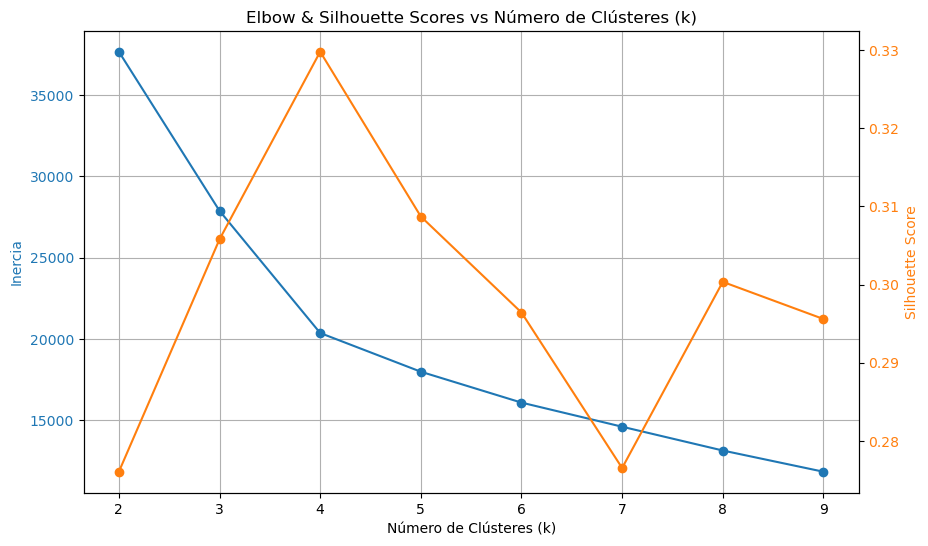

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Elbow (Inertia) on the left y-axis
ax1.set_xlabel('Número de Clústeres (k)')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.plot(k_range, inertia, marker='o', color='tab:blue', label='Inercia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Silhouette Score on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.plot(k_range, silhouette_scores, marker='o', color='tab:orange', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and grid
plt.title('Elbow & Silhouette Scores vs Número de Clústeres (k)')
ax1.grid(True)

plt.show()


## 6. Entrenar Modelo K-Means

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

## 7. Evaluación y visualización

In [22]:
# Score de silueta
score = silhouette_score(X_scaled, df['cluster'])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.330


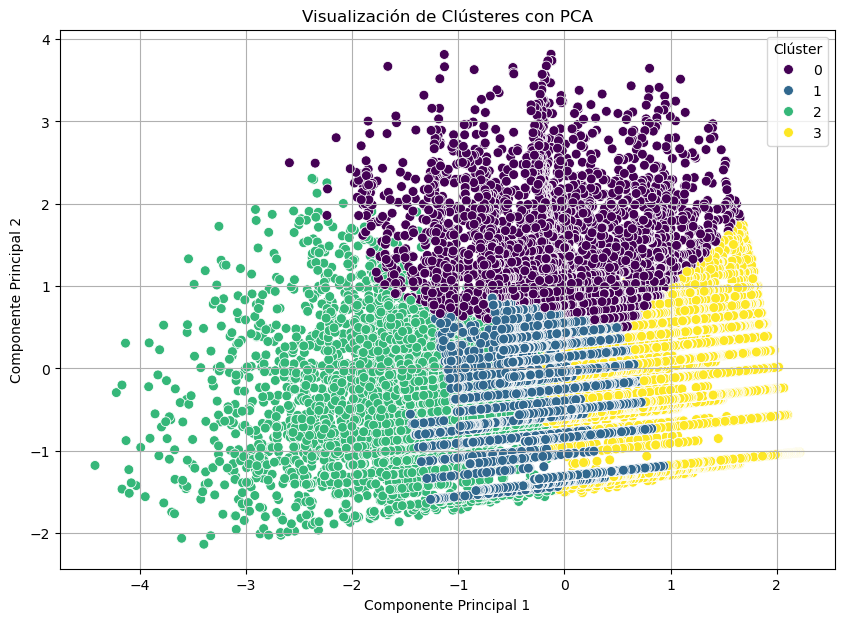

In [23]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# Aplicar PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear un nuevo DataFrame con los componentes principales y los clústeres
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

# Visualizar los clústeres en el espacio de los componentes principales
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis', s=50)

plt.title('Visualización de Clústeres con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clúster')
plt.grid()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Importación para gráficos 3D
import seaborn as sns

# Aplicar PCA para reducir a 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Crear un DataFrame con los 3 componentes y los clústeres
df_pca_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['cluster'] = df['cluster']

#Visualizar los clústeres en un gráfico 3D
import plotly.express as px

# Asumiendo que df_pca_3d tiene las columnas 'PC1', 'PC2', 'PC3' y 'cluster'
fig = px.scatter_3d(
    df_pca_3d, 
    x='PC1', 
    y='PC2', 
    z='PC3',
    color='cluster',
    title='Visualización de Clústeres con PCA en 3D',
    labels={'PC1': 'Componente Principal 1', 
            'PC2': 'Componente Principal 2', 
            'PC3': 'Componente Principal 3'}
)

fig.update_layout(
    height=800,
    width=800,
    scene=dict(
        aspectmode='cube' 
    )
)


fig.show()